*This script essentially uses the pre-trained SVM model to perform face detection on a test image using a sliding window approach at various scales. Detected bounding box coordinates are shown on the test image, providing visual representation of detected faces.*

### Table of Contents

* 1. [Importing Required Modules and Libraries](#1)
   
* 2. [Loading Pre-trained SVM Model](#2)

* 3. [Creating a Custom Transformer for Object Detection](#3)
   
* 4. [Defining Parameters for Object Detection](#4)
  
* 5. [Creating an Object Detection Pipeline](#5)

* 6. [Loading and Preparing a Test Image](#6)

* 7. [Performing Object Detection](#7)

* 8. [Displaying Results](#8)


<a id="1"> </a>
#### 1. Importing Required Modules and Libraries

* Import functions from a custom utility module.
* Import the joblib library for loading the pre-trained SVM model.
* Import necessary classes from scikit-learn for creating custom transformers.
* Import the Pipeline class for creating a processing pipeline.

In [1]:
from utils import *
import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt

<a id="2"> </a>
#### 2. Loading Pre-trained SVM Model

* Load a pre-trained SVM model that includes hard negatives. This model was trained using the script in _train_model.ipynb_.

In [2]:
svm_with_hard_negatives=joblib.load('svm_with_hard_negatives')

<a id="3"> </a>
#### 3. Creating a Custom Transformer for Object Detection

* ObjectDetectionTransformer class is defined, inheriting from BaseEstimator and TransformerMixin.
* The constructor (__init__) initializes the transformer with attributes including the pre-trained SVM model, window sizes, step size, downscale factor, and confidence threshold.
* detect_objects method takes an image and a window size, and performs object detection using a sliding window approach at different scales. It calculates HOG features for each window, predicts using the SVM model, and accumulates detections based on confidence scores.
* transform method takes input data (images) and returns detected bounding box coordinates after non-maximum suppression (see utils.py)

In [3]:
class ObjectDetectionTransformer(BaseEstimator, TransformerMixin):
    """
    A transformer class for object detection using a Support Vector Machine (SVM) model with hard negatives.

    Parameters:
    -----------
    svm_with_hard_negatives: object
        A trained SVM model with hard negatives for object detection.
    winSizes: list of tuples
        List of window sizes (width, height) for object detection at different scales.
    stepSize: int
        Step size for sliding window during object detection.
    downscale: float
        Scaling factor for resizing the image during object detection.
    threshold: float
        Confidence threshold for considering a detection.

    Methods:
    -----------
    detect_objects(image, winSize):
        Detects objects in the given image using a sliding window approach at different scales.

    fit(X, y=None):
        Empty method, as no training is required during the training phase of the pipeline.

    transform(X, y=None):
        Applies object detection to the input image at multiple scales and performs non-maximum suppression.

    """
    def __init__(self, svm_with_hard_negatives, winSizes, stepSize, downscale, threshold):
        self.svm_with_hard_negatives = svm_with_hard_negatives
        self.winSizes = winSizes
        self.stepSize = stepSize
        self.downscale = downscale
        self.threshold = threshold

    def detect_objects(self, image, winSize):
        """
        Detects objects in the given image using a sliding window approach at different scales.

        Parameters:
        -----------
        image: numpy.ndarray
            Input image for object detection.
        winSize: tuple
            Window size (width, height) for object detection.

        Returns:
        -----------
        detections: list
            List of detected bounding boxes (x1, y1, x2, y2) for objects in the image.
        """
        detections = []
        for scale in np.linspace(1.0, self.downscale, 5)[::-1]:
            resized_image = cv2.resize(image, (int(image.shape[1] / scale), int(image.shape[0] / scale)))
            for (x, y, window) in sliding_window(resized_image, self.stepSize, winSize):
                if window.shape[0] != winSize[1] or window.shape[1] != winSize[0]:
                    continue
                features = get_hog_features(window)
                confidence = self.svm_with_hard_negatives.decision_function([features])[0]
                if confidence >= self.threshold:
                    x = int(x * scale)
                    y = int(y * scale)
                    w = int(winSize[0] * scale)
                    h = int(winSize[1] * scale)
                    detections.append((x, y, x + w, y + h))
        return detections
    
    def fit(self, X, y=None):
        """
        Empty method, as no training is required during the training phase of the pipeline.

        Parameters:
        -----------
        X: array-like or pd.DataFrame
            Input data for fitting, not used in this method.
        y: array-like or pd.Series, optional
            Target variable, not used in this method.

        Returns:
        -----------
        self: object
            Returns self.
        """
        return self
        
    def transform(self, X, y=None):
        """
        Applies object detection to the input image at multiple scales and performs non-maximum suppression.

        Parameters:
        -----------
        X: numpy.ndarray
            Input image for object detection.
        y: None
            Target variable, not used in this method.

        Returns:
        -----------
        nms_detections: numpy.ndarray
            Array of bounding boxes (x1, y1, x2, y2) after non-maximum suppression.
        """
        all_detections = []
        for winSize in self.winSizes:
            detections = self.detect_objects(X, winSize)
            all_detections.extend(detections)
        nms_detections = non_max_suppression(np.array(all_detections), overlap_threshold=0.2)
        return nms_detections

<a id="4"> </a>
#### 4. Defining Parameters for Object Detection

* winSizes: A list of window sizes (bounding box dimensions) for object detection.
* stepSize: Step size for sliding window approach.
* downscale: A factor for resizing the image to detect objects at different scales.
* threshold: Confidence threshold for deciding if an object is detected.

<a id="5"> </a>
#### 5. Creating an Object Detection Pipeline

object_detection_pipeline is defined as a scikit-learn Pipeline with a single step using the ObjectDetectionTransformer. This pipeline encapsulates the object detection process.

In [4]:
winSizes = [(128, 128)]
stepSize = 10
downscale = 1.5
threshold = 0.7

object_detection_pipeline = Pipeline([
    ('object_detection', ObjectDetectionTransformer(svm_with_hard_negatives, winSizes, stepSize, downscale, threshold))
])

<a id="6"> </a>
#### 6. Loading and Preparing a Test Image

* test_image_path: Path to the test image file.
* test_image: Load the test image using OpenCV.

<a id="7"> </a>
#### 7. Performing Object Detection

nms_detections: Perform object detection using the defined pipeline on the test image.
If objects are detected, the bounding box coordinates are stored in the nms_detections array.

In [5]:
test_image_path = "test_face_detection/leclerc.jpg"
test_image = cv2.imread(test_image_path)

nms_detections = object_detection_pipeline.transform(test_image)

if len(nms_detections) > 0:
    bounding_box_list = nms_detections.tolist()
    print(f"Bounding Box List: {bounding_box_list}")
else:
    print("NO FACES DETECTED IN THE IMAGE")

Bounding Box List: [[250, 110, 378, 238]]


<a id="8"> </a>
#### 8. Displaying Results

* If no faces are detected, the script prints "NO FACES DETECTED IN THE IMAGE".
* If faces are detected:
  * The script creates a copy of the test image (result_image).
  * It draws green rectangles around the detected bounding boxes on result_image.
  * The modified image is displayed using OpenCV ( and matplotlib), showing the detected objects.

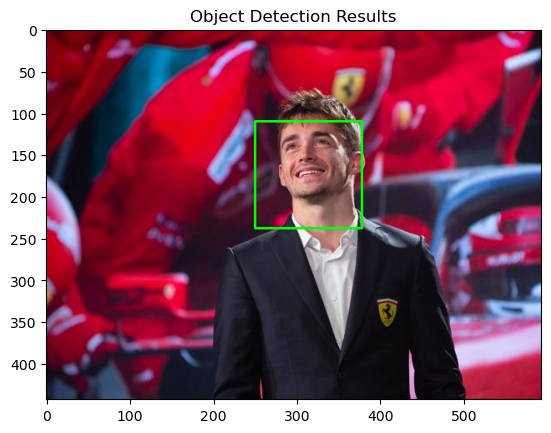

In [6]:
if len(nms_detections) == 0:
    print("NO FACES DETECTED IN THE IMAGE")
else:
    result_image = test_image.copy()
    for (x1, y1, x2, y2) in nms_detections:
        cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
    plt.title("Object Detection Results")
    plt.show()

Now I create an algorithm that ask to the user the image path in order to perform face detection on it

Enter the path to the image to be analysed (or type 'exit' to exit): test_face_detection/dua-lipa.jpg
How many faces do you expect to find in the picture? 1
Bounding Box List: [[233, 96, 409, 272]]


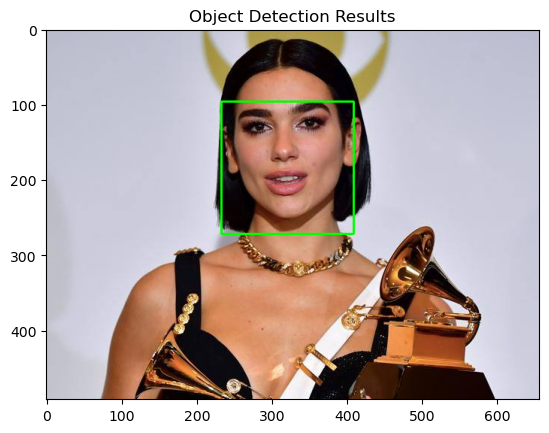

Would you like to analyse another image? (type 'yes' to continue, 'exit' to exit): yes
Enter the path to the image to be analysed (or type 'exit' to exit): test_face_detection/colosseum.jpg
How many faces do you expect to find in the picture? 0
NO FACES DETECTED IN THE IMAGE
Would you like to analyse another image? (type 'yes' to continue, 'exit' to exit): yes
Enter the path to the image to be analysed (or type 'exit' to exit): test_face_detection/evanescence.jpg
How many faces do you expect to find in the picture? 5
Bounding Box List: [[60, 180, 252, 372], [405, 180, 597, 372], [705, 150, 897, 342], [225, 180, 369, 324], [590, 170, 718, 298]]


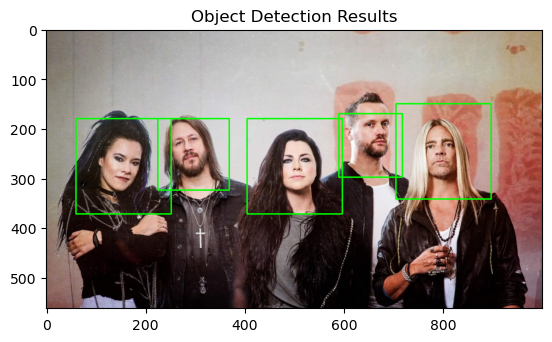

Would you like to analyse another image? (type 'yes' to continue, 'exit' to exit): exit


In [7]:
while True:
    # Ask the user for the image path
    image_path = input("Enter the path to the image to be analysed (or type 'exit' to exit): ")

    if image_path.lower() == 'exit':
        break  # Exit the loop if the user types 'exit'

    try:
        test_image = cv2.imread(image_path)
        if test_image is None:
            print("Error: Image cannot be read. Make sure the path is correct.")
            continue
    except Exception as e:
        print(f"Error: {e}")
        continue

    # Ask the user how many faces they expect to find in the image
    num_expected_faces = int(input("How many faces do you expect to find in the picture? "))

    # Perform your own object analysis
    nms_detections = object_detection_pipeline.transform(test_image)

    if len(nms_detections) > 0:
        bounding_box_list = nms_detections.tolist()
        print(f"Bounding Box List: {bounding_box_list}")

        result_image = test_image.copy()
        for (x1, y1, x2, y2) in nms_detections:
            cv2.rectangle(result_image, (x1, y1), (x2, y2), (0, 255, 0), 2)

        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title("Object Detection Results")
        plt.show()

    else:
        print("NO FACES DETECTED IN THE IMAGE")

    # Keep asking the user if he/she wants to analyse another image
    continue_analysis = input("Would you like to analyse another image? (type 'yes' to continue, 'exit' to exit): ")
    if continue_analysis.lower() != 'yes':
        break  # Exit the loop if the user does not wish to continue